In [22]:
import matplotlib.pyplot as plt
import json
import pandas as pd
from pandas.io.json import json_normalize
%matplotlib notebook
import seaborn as sns
from pylab import *
# author: jsara72
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
import random
import nltk
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk import word_tokenize
import pandas as pd
import re
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
import numpy as np
from matplotlib import pyplot as plt
import math
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sns.set_style("white")
colors = sns.color_palette("hls", 8)

# FUNCTIONS

In [7]:
def _init_struct_(fname):
    
    f = open(fname)
    
    order = ['id','time','text','language','retweeted','user_id']
    
    idt = re.compile("id:.*?created_at:")
    idt_temp = list(map(lambda x: re.sub(r'[^\x00-\x7F]+',' ', x[3:-13]), idt.findall(f.read())))
    
    f.seek(0)
    time = re.compile("created_at:.*?text:")
    time_temp = list(map(lambda x: re.sub(r'[^\x00-\x7F]+',' ', x[11:-7]), time.findall(f.read())))
    
    f.seek(0)

    text = re.compile("text:.*?lang:",re.DOTALL)
    text_temp = list(map(lambda x: re.sub(r'[^\x00-\x7F]+',' ', x[5:-7]), text.findall(f.read())))
    
    
    f.seek(0)
    length = re.compile("lang:.*?source:")
    length_temp = list(map(lambda x: re.sub(r'[^\x00-\x7F]+',' ', x[5:-9]), length.findall(f.read())))
    
    f.seek(0)
    retweeted = re.compile("retweeted:.*?retweet_count:")
    retweeted_temp = list(map(lambda x: re.sub(r'[^\x00-\x7F]+',' ', x[10:-16]), retweeted.findall(f.read())))
    
    f.seek(0)
    retweet_counts = re.compile("retweet_counts:.*")
    retweet_counts_temp = list(map(lambda x: re.sub(r'[^\x00-\x7F]+',' ', x[14:-1]), retweet_counts.findall(f.read())))
    
    f.seek(0)
    user_id_raw = re.findall(",[\w\d\-]+,\d+,['\+\w/\.\-\s\(\)&]+,['\w\s\^\$\*\+\?\{\}\[\]\\\|\(\)\.\-@:%\+~#\?&/=!]+,-?[\d\w]+,\w+], entities:", f.read())
    user_id = [re.findall(",.*?,",x)[0] for x in user_id_raw]
    # just for test
    '''f.seek(0)

    user_id_greedy = re.findall(".*?entities:", f.read())
    for u_g in user_id_greedy:
        matched = False
        for u_id in user_id:
            if u_id in u_g:
                matched = True
        if not matched:
            print(u_g)
    '''# end
    user_id_temp = list(map(lambda x: re.sub(r'[^\x00-\x7F]+',' ', x[1:-1]), user_id))
   
    print(len(idt_temp),len(time_temp),len(text_temp),len(length_temp),len(retweeted_temp),len(user_id_temp))
    #print(user_id_temp)
    
    df = pd.DataFrame({order[0]: idt_temp,
                        order[1]: time_temp,
                        order[2]: text_temp,
                        order[3]: length_temp,
                        order[4]: retweeted_temp,
                        order[5]: user_id_temp})
    return df

In [33]:
def load_files(fname1,fname2):
    df1 = _init_struct_(fname1)
    df2 = _init_struct_(fname2)
    df = pd.concat([df1, df2],ignore_index=True)
    return df

def get_filtered_tokens(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [w.lower() for w in tokens if not w.lower() in stop_words and not w.lower() in otherfilters and not len(w.lower()) < 4 and not w.lower() in keywords]
    #I added len(w.lower()) < 4 to filter out really short words
    return nltk.FreqDist(filtered_tokens).most_common(20) #change 20 -> x for x most frequent words
   #return filtered_tokens

def get_filtered_tokens2(text):
    
    keywords = ['womensmarch', 'women', 'march', 'washington', 'rights', 'woman', 'london','womensmarchonwashington']
    otherfilters = ['!','?',':',"#", '@', 'https', ';','&', ',','.','rt','-','...']
    tokens = word_tokenize(text)
    #stop_words = set(stopwords.words('english'))
    filtered_tokens = [w.lower() for w in tokens if not w.lower() and not w.lower() in [':',"#", '@', 'https', ';','&', ',']]
    #print(nltk.FreqDist(filtered_tokens).most_common(200))
   #return filtered_tokens

# INITIALIZE DATA PROCESSING

In [9]:
df = load_files('part-00000','part2-00000')

36725 36725 36725 36725 36725 36725
91819 91819 91819 91819 91819 91819


In [10]:
df.head()

,id,language,retweeted,text,time,user_id
0,822707826460073985,en,false,A guy who is so excited to draw a uterus on a ...,Sat Jan 21 07:30:05 +0000 2017,emmakahen
1,822707847440035840,en,false,@womensmarchlon Sorry I can't be there today. ...,Sat Jan 21 07:30:10 +0000 2017,f4rheen
2,822707893581578240,en,false,Worldwide Womens March kicks off in New Zea...,Sat Jan 21 07:30:21 +0000 2017,blackmoonlili
3,822707927140052992,ja,false,RT @channel__3: 2000 #WomensMarch \nhttps://t...,Sat Jan 21 07:30:29 +0000 2017,Zero_B_Eventail
4,822707943938420736,en,false,RT @politicalmiller: While Trump's #Inaugurati...,Sat Jan 21 07:30:33 +0000 2017,Amplitude350Lee


# DUPLICATED TWEETS 

In [18]:
dd = df.duplicated(['id'])
df['duplicate_id'] = dd
#appends a new column that tells us if this tweet is a repeat
# we need to filter these tweets out!
dd = df.duplicated(['user_id'])
df['duplicate_user'] = dd
#appends a new column that tells us if this tweet is by a new user
# with no other tweets in our dataset
df1 = df.loc[lambda df: df['duplicate_id'] == 0]
#new dataframe df_filtered with repeat tweets filtered out (this keeps first version but not repeated version)
df2 = df.loc[lambda df: df['duplicate_user'] == 0]
#new dataframe with only tweets by users who haven't tweeted yet
df3 = df.loc[lambda df: df['duplicate_user'] == 1]
#new dataframe with only tweets from users who tweeted before

print('# tweets...') 
print(len(df))
print('# of first tweets')
print(len(df2))
print('# of tweets by same users')
print(len(df3))

# tweets...
128544
# of first tweets
113741
# of tweets by same users
14803


# SENTIMENT ANALYSIS

In [59]:
#nltk sentiment analysis
sid = SentimentIntensityAnalyzer()

#df['compound'] = np.zeros(len(df))
df['compound']=df.text.apply(lambda x:sid.polarity_scores(x)['compound'])
df['sent_neut']=df.text.apply(lambda x:sid.polarity_scores(x)['neu'])
df['sent_neg']=df.text.apply(lambda x:sid.polarity_scores(x)['neg'])
df['sent_pos']=df.text.apply(lambda x:sid.polarity_scores(x)['pos'])
df['sentiment_type']=''
df.loc[df['compound']>0,'sentiment_type']='POS'
df.loc[df['compound']==0,'sentiment_type']='NEUT'
df.loc[df['compound']<0,'sentiment_type']='NEG'
del df['sentiment_compound_polarity']

In [76]:
import pickle

from sentiment_analysis import train_classifier, VoteClassifier, find_features, get_filtered_tokens

vclassifier = train_classifier()


/Users/Griffin/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DictVectorizer from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/Griffin/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator NuSVC from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/Griffin/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/Griffin/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LinearSVC from version pre-0.18 when using version 0.18.1. This might lead to breaking co

In [85]:
#Classifier 2: homemade version


def classify_tweet(text, classifier):
    tokens = get_filtered_tokens(text)
    cl = classifier.classify(find_features(text, tokens))
    cnf = classifier.confidence(find_features(text, tokens))
    return cl, cnf

class_conf = df['text'].apply(lambda x:classify_tweet(x, vclassifier))
a,b = zip(*class_conf)
df['vote_classifier'] = list(a)
df['vote_classifier_confidence'] = list(b)
# df['vote_classifier_confidence'] = df['text'].apply(lambda x:vclassifier.confidence(x, vclassifier))

In [87]:
score = np.zeros(len(df))

for i in range(len(df)):
    score[i] = 2*((df['vote_classifier'][i] - 0.5)*df['vote_classifier_confidence'][i])
    
df['homemade_score'] = score

In [115]:
times_df = df['datetime_times']
series = pd.Series(1, index=times_df)
times_df_60minbins = series.resample('60T').sum()

series_nltk = pd.Series(list(df['compound']), index=times_df)
compound_60min = series_nltk.resample('60T').sum()
series_homemade = pd.Series(score, index=times_df)
homemadescore_60min = series_homemade.resample('60T').sum()

compound_60min_norm = compound_60min/times_df_60minbins
homemadescore_60min_norm = homemadescore_60min/times_df_60minbins

<IPython.core.display.Javascript object>


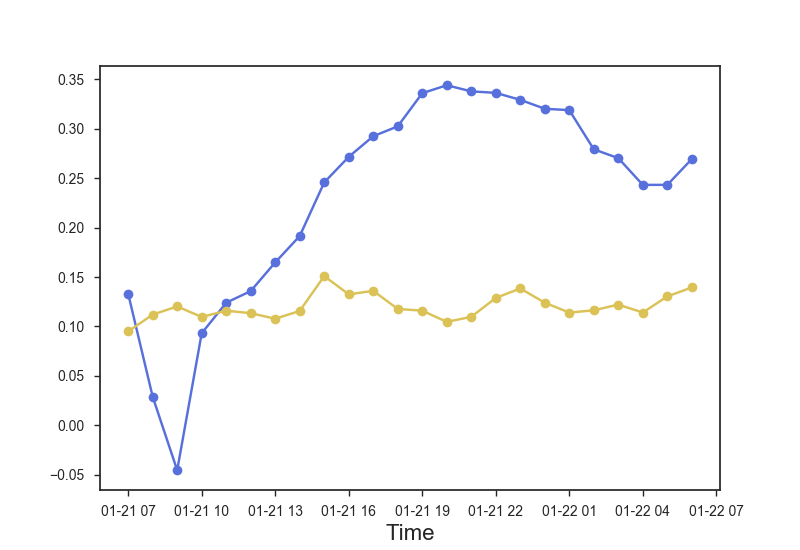

In [118]:

sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})
fig, ax = plt.subplots(1)
c1 = ax.plot(homemadescore_60min_norm, 'o-', color = colors[5])
c2 = ax.plot(compound_60min_norm, 'o-', color = colors[1])
ax.set_xlabel('Time',fontsize = 16)
#ax.set_ylabel('Frequency',fontsize = 16)
#ax.legend((p1, p2), ('@s', 'RTs'), fontsize = 13)


# Sentiment Analysis on top words

In [129]:
from co_ocurrance import get_filtered_words
trump_score_nltk = []
for i in range(len(df)):
    words, tags = get_filtered_words(df['text'].values[i])
    if 'love' in words:
        trump_score_nltk.append(df['compound'][i])
# print(trump_score)
print("mean: ", np.mean(trump_score_nltk))
print("std: ", np.std(trump_score_nltk))

mean:  0.717039402985
std:  0.244127589657


In [130]:
from co_ocurrance import get_filtered_words
trump_score = []
for i in range(len(df)):
    words, tags = get_filtered_words(df['text'].values[i])
    if 'love' in words:
        trump_score.append(df['homemade_score'][i])
# print(trump_score)
print("mean: ", np.mean(trump_score))
print("std: ", np.std(trump_score))

mean:  0.405281285878
std:  0.589616439381


# Counting

In [19]:
# Putting tweets into 10 minute bins so we can make a histogram of tweets vs. time
# change '10T' to 'xT' for x-minute bin size
times_df = df['datetime_times']
series = pd.Series(1, index=times_df)
times_df_10minbins = series.resample('10T').sum()

times_df2 = df2['datetime_times']
series2 = pd.Series(1, index=times_df2)
times_df2_10minbins = series2.resample('10T').sum()

times_df3 = df3['datetime_times']
series3 = pd.Series(1, index=times_df3)
times_df3_10minbins = series3.resample('10T').sum()

#appending a datetime form of the 'time' column to our dataframes (this is easier to work with in pandas)
aaa = df['time']
times_df = pd.to_datetime(aaa)
df['datetime_times'] = times_df
bbb = df2['time']
times_df2 = pd.to_datetime(bbb)
df2['datetime_times'] = times_df2
ccc = df3['time']
times_df3 = pd.to_datetime(ccc)
df3['datetime_times'] = times_df3

for i in range(len(times_df3_10minbins)):
    t = times_df3_10minbins.values[i]
    if math.isnan(t)==True:
        times_df3_10minbins.values[i] = 0.
        
# Putting tweets into 10 minute bins so we can make a histogram of tweets vs. time
# change '10T' to 'xT' for x-minute bin size
times_df = df['datetime_times']
series = pd.Series(1, index=times_df)
times_df_30minbins = series.resample('30T').sum()
times_df_largebins = series.resample('90T').sum()


times_df2 = df2['datetime_times']
series2 = pd.Series(1, index=times_df2)
times_df2_30minbins = series2.resample('30T').sum()
times_df2_largebins = series2.resample('90T').sum()


times_df3 = df3['datetime_times']
series3 = pd.Series(1, index=times_df3)
times_df3_30minbins = series3.resample('30T').sum()
times_df3_largebins = series3.resample('90T').sum()

x2_axis=np.arange(len(times_df3_30minbins))
test1 = np.linspace(0,46,23)
test2 = times_df2_30minbins.index[::4]
xlabels_30mins = ['07:30','08:30','09:30','10:30','11:30','12:30','13:30','14:30','15:30','16:30','17:30','18:30','19:30','20:30','21:30','22:30','23:30','00:30','01:30','02:30','03:30','04:30','05:30','06:30']
xlabels_1hour = ['03:30','','05:30','','07:30','','09:30','','11:30','','13:30','','15:30','','17:30','','21:30','','23:30','','01:30','','03:30','']

#creating larger time bins for ratio and rate calculations to reduce noise


/Users/Griffin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Griffin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
ratio = times_df2_largebins/times_df3_largebins
xaxis2 = np.linspace(0,16,17)
xlabels_1hour2 = ['03:30','','06:30','','09:30','','12:30','','15:30','','18:30','','21:30','','00:30','','03:30']

<IPython.core.display.Javascript object>


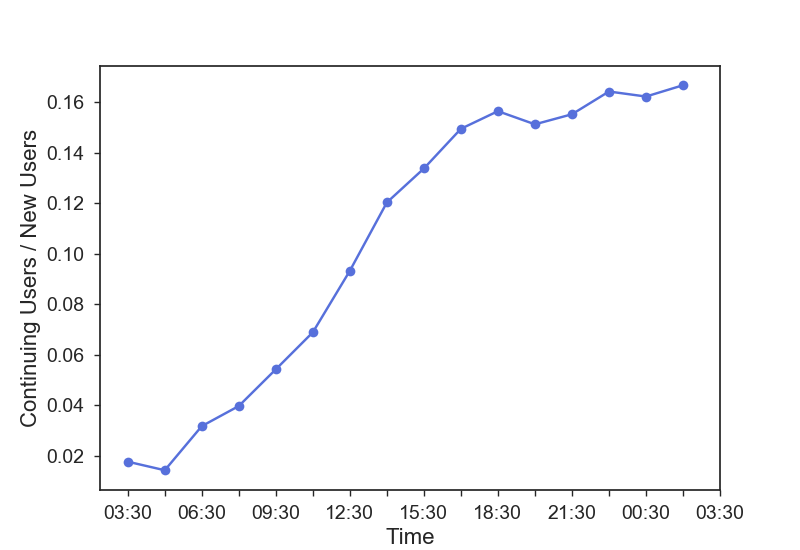

In [92]:
xaxis = list(range(0,len(ratio)))

sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})
fig, ax = plt.subplots(1)
ax.plot(xaxis, 1/ratio, 'o-', color = colors[5])
ax.set_xticks(xaxis2)
ax.tick_params(axis ='y', labelsize=14)
ax.tick_params(axis ='x', labelsize=14)
#ax.set_yticklabels(1/ratio, fontsize = 12)
ax.set_xticklabels(xlabels_1hour2)
ax.set_xlabel('Time',fontsize = 16)
ax.set_ylabel('Continuing Users / New Users',fontsize = 16)
#ax.set_title('Ratio of Continuing Users to New Users Over Time',fontsize = 16)

<IPython.core.display.Javascript object>


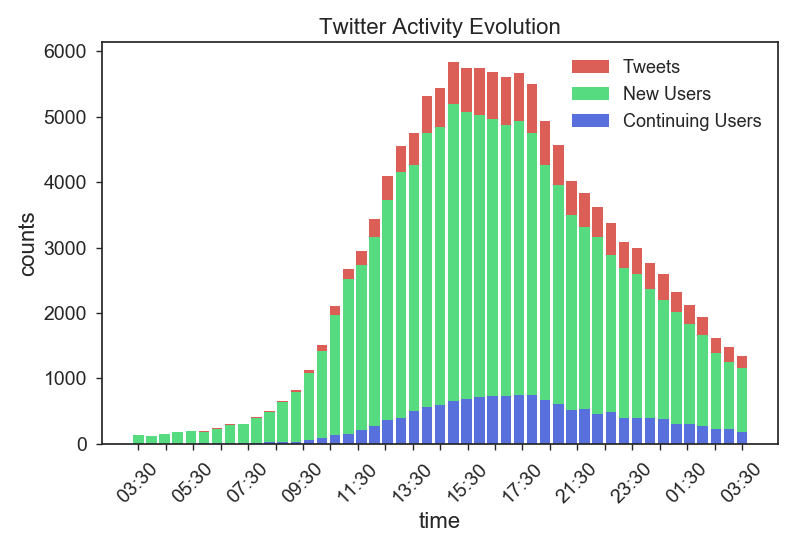

In [24]:
#plotting # all tweets vs time (p1, blue) and # tweets from new users
# vs time (p2, red)
colors = sns.color_palette("hls", 8)
x2_axis=np.arange(len(times_df3_30minbins))
fig, ax = plt.subplots(1)
ind = x2_axis 
width_sep = 0.5
b1 = ax.bar(ind, times_df_30minbins,color=colors[0])
b2 = ax.bar(ind, times_df2_30minbins,color = colors[3])
b3 = ax.bar(ind, times_df3_30minbins, color = colors[5])
ax.tick_params(axis ='y', labelsize=14)
ax.set_xticks(test1)
ax.set_xticklabels(xlabels_1hour, rotation = 45,fontsize = 14)
ax.set_xlabel('time',fontsize = 16)
ax.set_ylabel('counts',fontsize = 16)
ax.legend((b1, b2, b3), ('Tweets', 'New Users', 'Continuing Users'),fontsize = 13)
ax.set_title('Twitter Activity Evolution',fontsize = 16)

In [43]:
# obtaining the number of @-mentions, number of manual retweets, and number of manual retweets with an @ in them
at_count = np.zeros(len(df['text']))
RT_count = np.zeros(len(df['text']))
RT_at_count = np.zeros(len(df['text']))

for i in range(len(df['text'].values)):
    tokens = [ s.lower() for s in word_tokenize(df['text'].values[i])]
    for j in range(len(tokens)):
        if tokens[j]=='@':
            at_count[i] +=1
        elif tokens[j]=='rt':
            RT_count[i] +=1
            for k in range(len(tokens)):
                if tokens[k]=='@':
                    RT_at_count[i] +=1
                    break    
print('total number of tweets...')
print(len(df))
print('number of @...')
print(np.sum(at_count))
print('number of RT...')
print(np.sum(RT_count))
print('number of RT with an @...')
print(np.sum(RT_at_count))

total number of tweets...
128544
number of @...
131297.0
number of RT...
106653.0
number of RT with an @...
106515.0


<IPython.core.display.Javascript object>


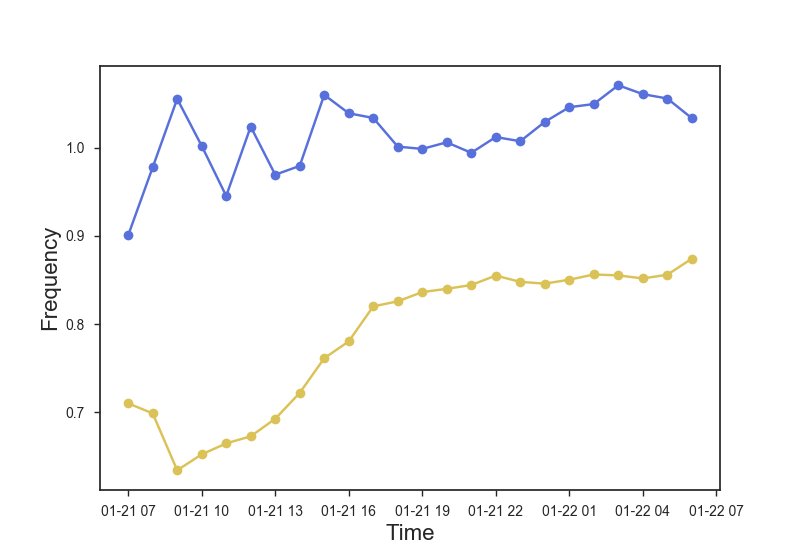

/Users/Griffin/anaconda/lib/python3.6/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x11e137128>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
/Users/Griffin/anaconda/lib/python3.6/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1262b2c50>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


In [51]:
times_df = df['datetime_times']
series = pd.Series(1, index=times_df)
times_df_60minbins = series.resample('60T').sum()
series_at = pd.Series(at_count, index=times_df)
at_60min = series_at.resample('60T').sum()
series_rt = pd.Series(RT_count, index=times_df)
rt_60min = series_rt.resample('60T').sum()

at_60min_norm = at_60min/times_df_60minbins
rt_60min_norm = rt_60min/times_df_60minbins

xaxis = list(range(0,len(at_count)))
xaxis2 = np.linspace(0,16,17)
xlabels_1hour2 = ['03:30','','06:30','','09:30','','12:30','','15:30','','18:30','','21:30','','00:30','','03:30']

sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})
fig, ax = plt.subplots(1)
p1 = ax.plot(at_60min_norm, 'o-', color = colors[5])
p2 = ax.plot(rt_60min_norm, 'o-', color = colors[1])
ax.set_xlabel('Time',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.legend((p1, p2), ('@s', 'RTs'), fontsize = 13)

# SELF-AWARENESS

In [29]:
#counts then number of I's, you's and we's. Gives info about self-awareness.
i_count = np.zeros(len(df['text']))
you_count = np.zeros(len(df['text']))
we_count = np.zeros(len(df['text']))

for i in range(len(df['text'].values)):
    tokens = [ s.lower() for s in word_tokenize(df['text'].values[i])]
    for j in range(len(tokens)):
        if tokens[j]=='i':
            i_count[i] +=1
        elif tokens[j]=='you':
            you_count[i] +=1
        elif tokens[j]=='we':
            we_count[i] +=1
            
print('Mean number of 1st person singular...') 
print(np.mean(i_count))
print('Mean number of 1st person plural...') 
print(np.mean(we_count))
print('Mean number of 2nd person...') 
print(np.mean(you_count))
print('Std 1st person singular...')
print(np.std(i_count))
print('Std 1st person plural...')
print(np.std(we_count))
print('Std 2nd person...')
print(np.std(you_count))

Mean number of 1st person singular...
0.155339805825
Mean number of 1st person plural...
0.0912450211601
Mean number of 2nd person...
0.100136918098
Std 1st person singular...
0.446964553087
Std 1st person plural...
0.33780898628
Std 2nd person...
0.371085049134


# MOST FREQUENT WORDS 

In [37]:
keywords = ['womensmarch', 'women', 'march', 'washington', 'rights', 'woman', 'london','womensmarchonwashington']
otherfilters = ['!','?',':',"#", '@', 'https', ';','&', ',','.','rt','-','...']

appended_text = ''
for t in df['text']:
    appended_text += t
#getting most frequent words (with length > 3)
topwords = get_filtered_tokens(appended_text)
topwords = np.array(topwords)

#changing the number of topwords from string to int
for i in range(len(topwords[:,1])):
    t = int(topwords[i,1])
    topwords[i,1] = t
t = map(int, topwords[:,1])
t = np.array(list(t))
t = t/len(df)
w = topwords[:,0]   
print(w)

['today' 'trump' 'marching' 'people' 'womensmarchrt' 'love' 'proud'
 'protest' 'inauguration' 'world' 'like' 'marches' 'sign' 'crowd' 'signs'
 'history' 'around' 'america' 'right' 'thanks']


<IPython.core.display.Javascript object>


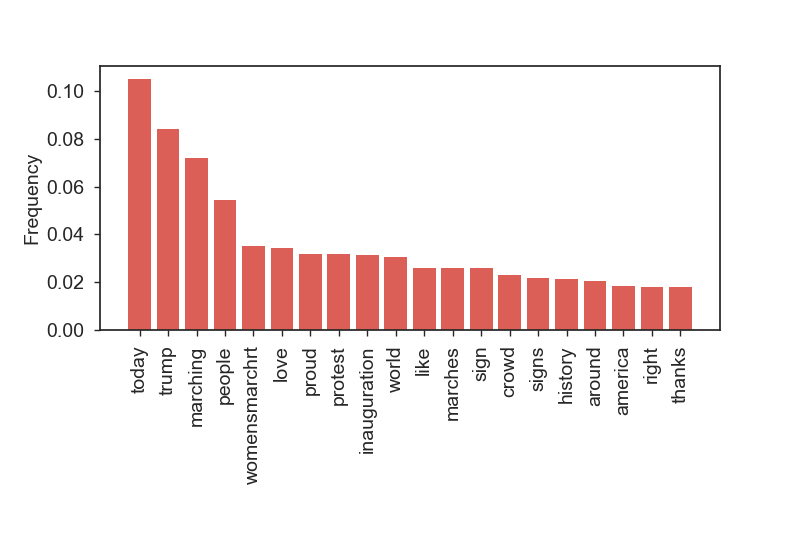

In [42]:
x_axis=np.arange(len(w))
plt.tight_layout()
fig, ax = plt.subplots(1)
fig.subplots_adjust(bottom = 0.4)
ind = x_axis 
width_sep = 1
ax.tick_params(axis ='y', labelsize=14)
ax.bar(ind, t,color = colors[0])
ax.set_xticks(ind)
ax.set_xticklabels(w, rotation = 90, fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
#ax.set_title('20 Most Frequent Words (excluding keywords)', fontsize = 14)